In [ ]:
import os
import random
import shutil
import glob
import cv2
from glob import glob
import numpy as np
import pandas as pd


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Reshape, concatenate, Concatenate, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard,LearningRateScheduler

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle

from datetime import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
!unzip -q /content/drive/MyDrive/Data/BrainMRI2.zip

In [ ]:
BATCH_SIZE = 16
EPOCHS = 100
LEARNING_RATE = 0.0001
NUM_CLASSES = 4
SPLIT = 0.2
SEED = 42
SIZE = 256

In [ ]:
df = pd.read_csv('/content/lgg-mri-segmentation/kaggle_3m/data.csv')
df.head()

data_dir = '/content/lgg-mri-segmentation/kaggle_3m'

mask_paths = glob(f'{data_dir}/*/*_mask*')
total_affected_cases = 0

for path in mask_paths:
    # Load the mask image
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    # Count the number of non-zero pixels (tumor region) in the mask
    num_pixels = np.count_nonzero(mask)

    if num_pixels > 0:
        total_affected_cases += 1

total_non_affected = 3929 - total_affected_cases
print("Total affected tumor cases:", total_affected_cases)
print("Total Non-Affected tumor cases:", total_non_affected)

Total affected tumor cases: 1373
Total Non-Affected tumor cases: 2556


In [ ]:
def create_df(data_dir):
    images_paths = []
    masks_paths = glob(f'{data_dir}/*/*_mask*')

    for i in masks_paths:
        images_paths.append(i.replace('_mask', ''))

    df = pd.DataFrame(data= {'images_paths': images_paths, 'masks_paths': masks_paths})

    return df

def split_df(df):
    train_df, dummy_df = train_test_split(df, train_size= 0.8, random_state = SEED) #random_state for randomly splitting the dataset. rain size with a ratio of 8:2

    valid_df, test_df = train_test_split(dummy_df, train_size= 0.5, random_state = SEED) #randomly split test data set with 5:5 ratio to get both validation and test data set

    return train_df, valid_df, test_df


def create_generator(df,cmd,size):

  datagen = ImageDataGenerator(**cmd)
  mask_data = ImageDataGenerator(**cmd)

  image_gen = datagen.flow_from_dataframe(df, x_col='images_paths', class_mode=None, color_mode='rgb', target_size=(size,size),
                                            batch_size=BATCH_SIZE, save_to_dir=None, save_prefix='image', seed=1)

  mask_gen = mask_data.flow_from_dataframe(df, x_col='masks_paths', class_mode=None, color_mode='grayscale', target_size=(size,size),
                                            batch_size=BATCH_SIZE, save_to_dir=None, save_prefix= 'mask', seed=1)

  generator = zip(image_gen,mask_gen)

  for (image,mask) in generator:
    image = image / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    yield (image, mask)


def show_images(images, masks):
    plt.figure(figsize=(12, 12))
    for i in range(10):
        plt.subplot(5, 5, i+1)
        img_path = images[i]
        mask_path = masks[i]
        # read image and convert it to RGB scale
        image = cv2.imread(img_path)
        # read mask
        mask = cv2.imread(mask_path)
        # sho image and mask
        plt.imshow(image)
        plt.imshow(mask, alpha=0.4)

        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
dir = '/content/lgg-mri-segmentation/kaggle_3m'

df = create_df(dir)
train_df, valid_df, test_df = split_df(df)

datagen_cmd = dict(
  rotation_range=0.2,
  width_shift_range=0.05,
  height_shift_range=0.05,
  shear_range=0.05,
  zoom_range=0.05,
  horizontal_flip=True,
  fill_mode='nearest')


print("Number of Total Dataset =", len(df))
print("Number of Train Dataset =", len(train_df))
print("Number of Validation Dataset =", len(valid_df))
print("Number of Test Dataset =", len(test_df))

Number of Total Dataset = 3929
Number of Train Dataset = 3143
Number of Validation Dataset = 393
Number of Test Dataset = 393


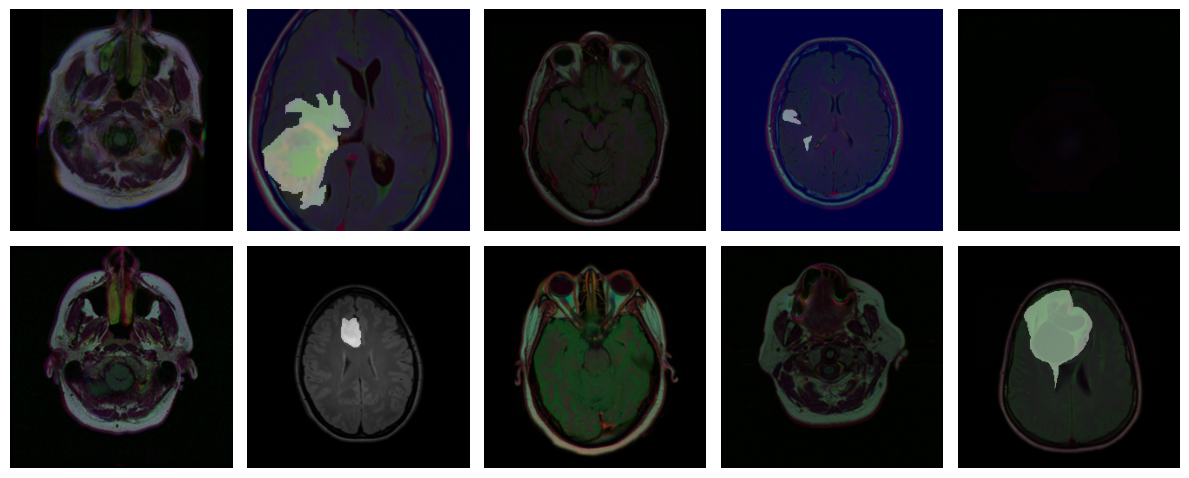

In [ ]:
train_generator = create_generator(train_df, cmd = datagen_cmd, size = 256)
val_generator = create_generator(valid_df, cmd = {}, size = 256)
test_generator = create_generator(test_df, cmd = {}, size = 256)

show_images(list(train_df['images_paths']), list(train_df['masks_paths']))

Found 3143 validated image filenames.
Found 3143 validated image filenames.


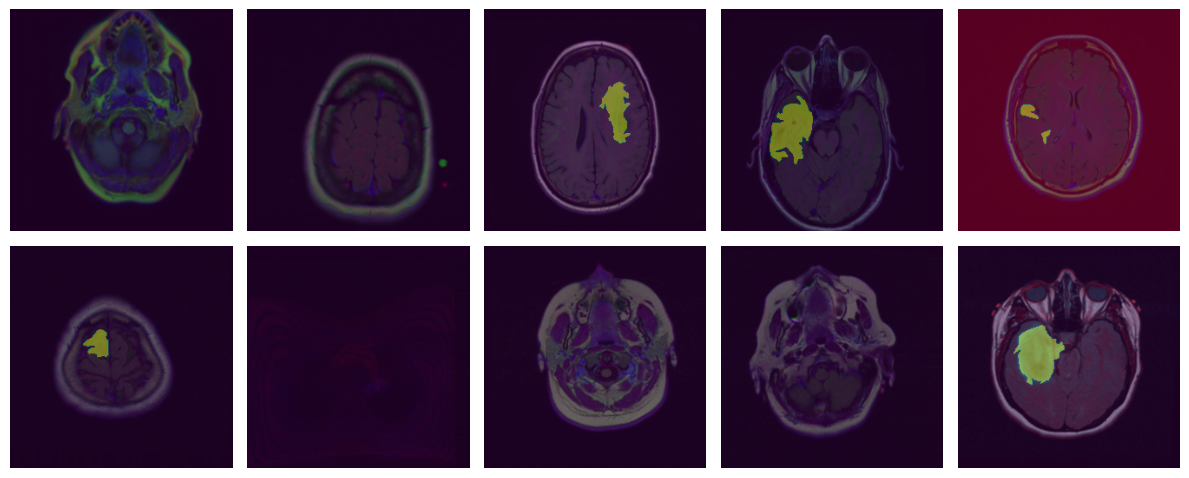

In [ ]:
train_generator_test = create_generator(train_df, cmd = datagen_cmd, size = 256)

def show_images_augmented(generator):
    plt.figure(figsize=(12, 12))
    images, masks = next(generator)
    for i in range(10):
        plt.subplot(5, 5, i+1)
        img_path = images[i]
        mask_path = masks[i]

        # sho image and mask
        plt.imshow(img_path)
        plt.imshow(mask_path, alpha=0.4)

        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_images_augmented(train_generator_test)

# DeepLab

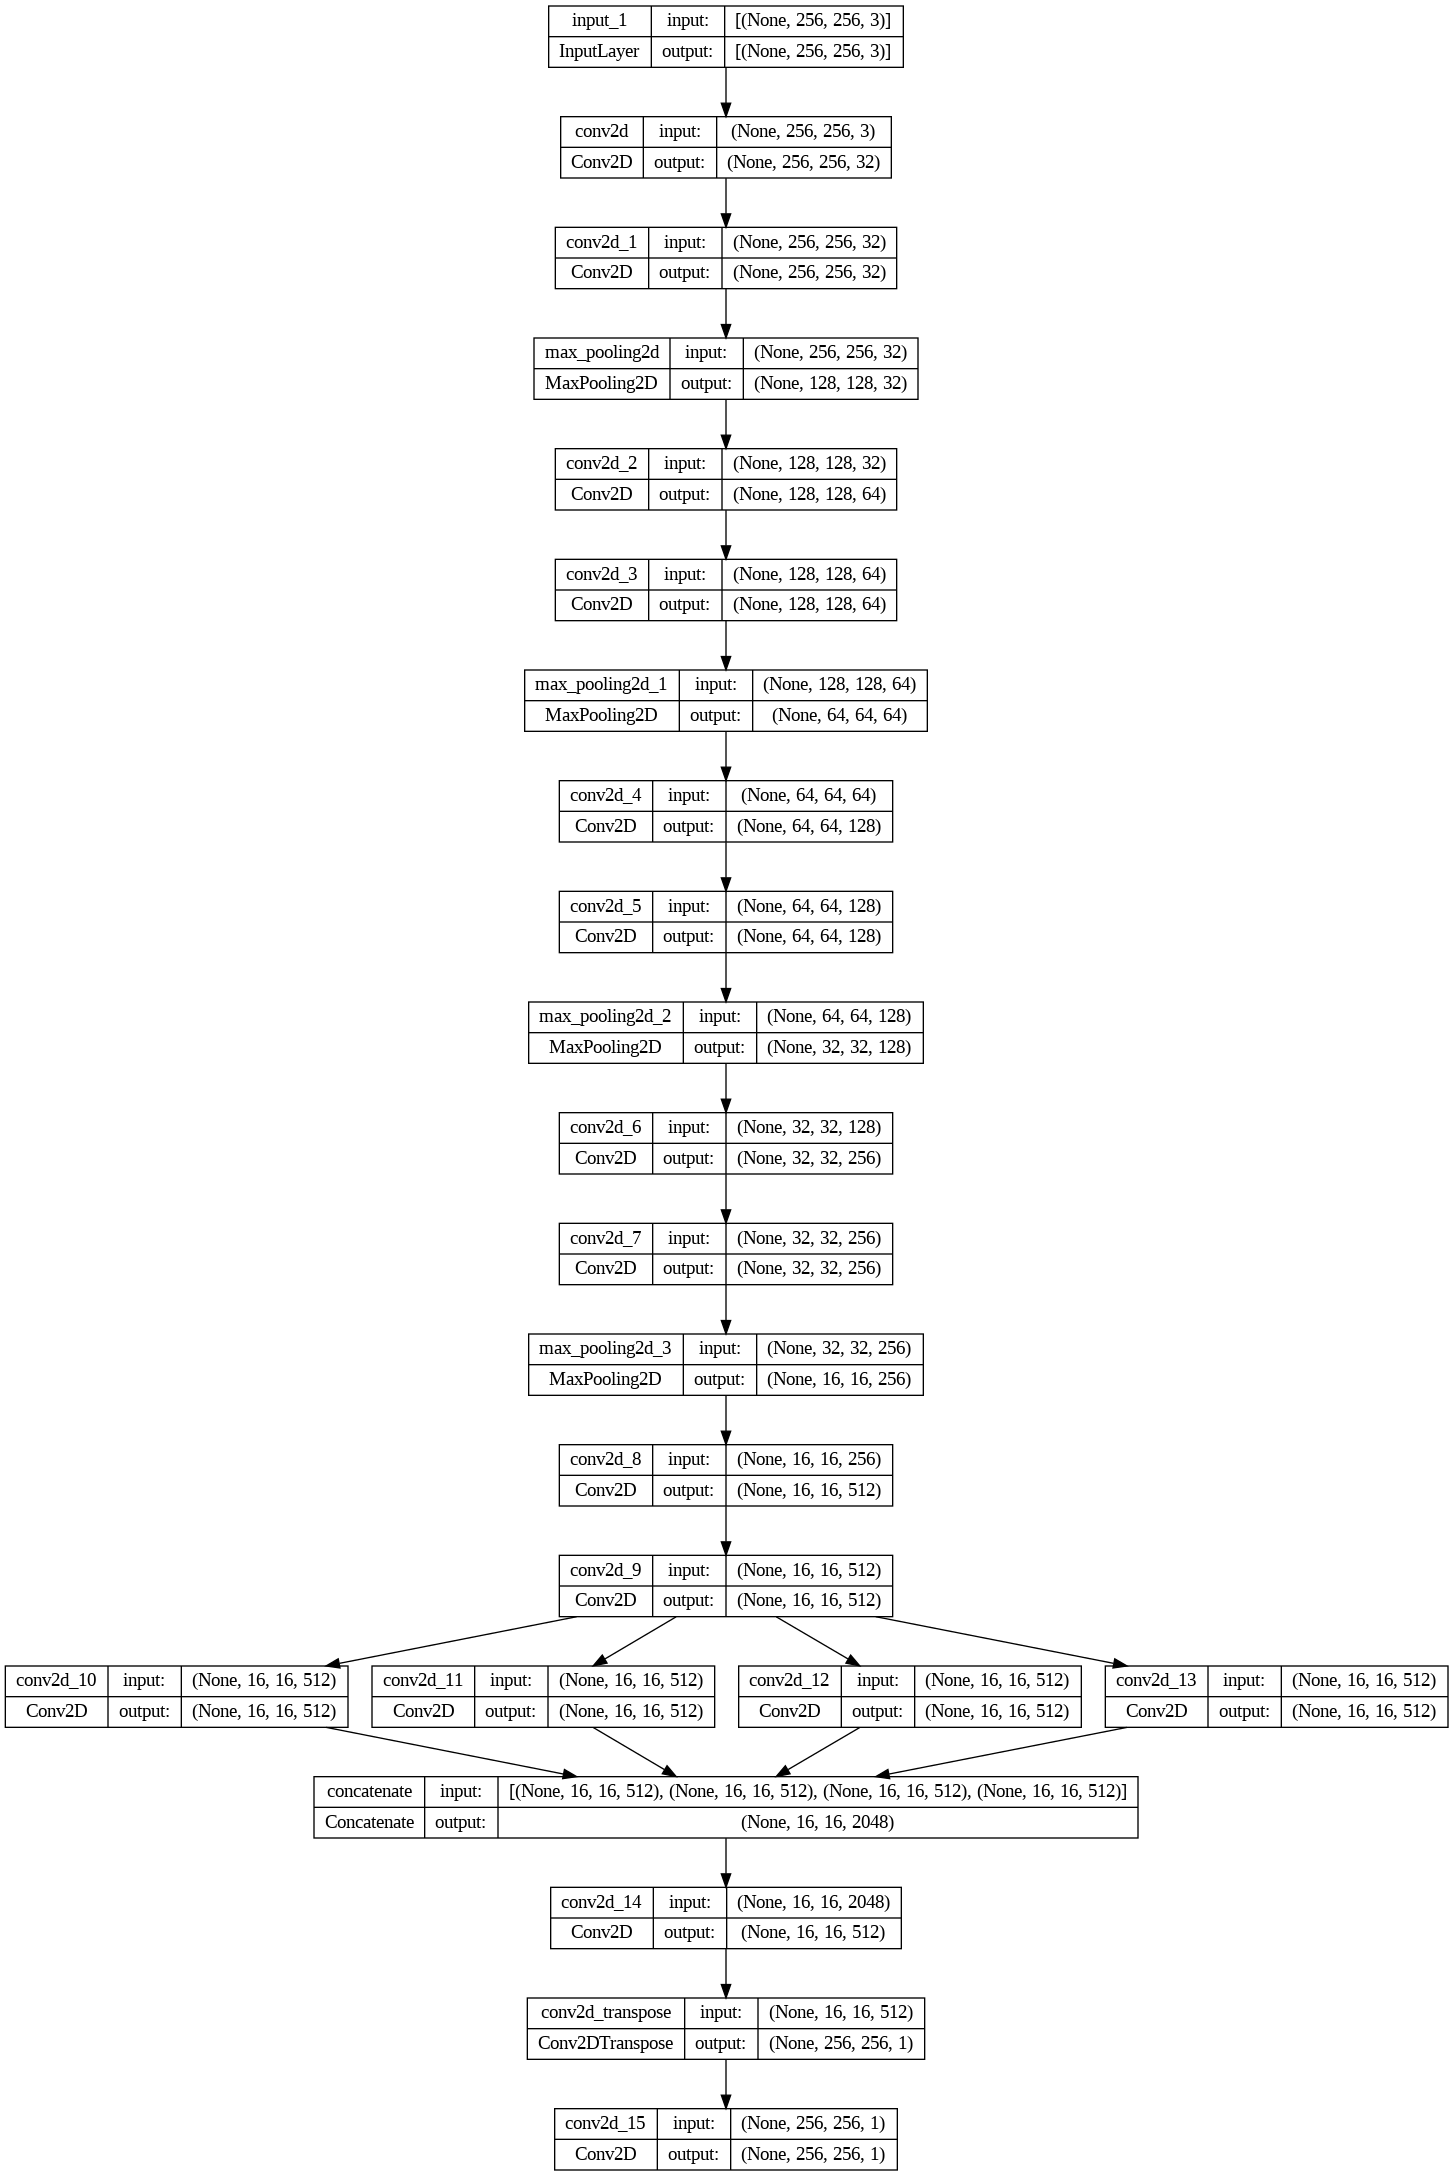

In [ ]:
def deeplab_model():

    atrous_rates = [6, 12, 18, 24]
    inputs = Input((SIZE, SIZE, 3))

    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    # Atrous (dilated) Convolutions with Different Rates
    atrous_layers = []
    for rate in atrous_rates:
        atrous_layer = Conv2D(512, 3, activation='relu', padding='same', dilation_rate=rate)(conv5)
        atrous_layers.append(atrous_layer)

    # Concatenated Atrous Layers
    concat = Concatenate(axis=-1)(atrous_layers)

    # Decoder
    conv6 = Conv2D(512, 1, activation='relu', padding='same')(concat)

    upsample = Conv2DTranspose(1, kernel_size=16, strides=16, padding='same')(conv6)
    outputs = Conv2D(1, 1, activation='sigmoid')(upsample)

    model = Model(inputs=[inputs], outputs=[outputs])

    display(tf.keras.utils.plot_model(model, to_file='deeplabv1.png', show_shapes=True))

    return model

deepmodel = deeplab_model()

In [ ]:
deepmodel.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
def scheduler(epoch, lr):
      if epoch < 5:
        return lr
      else:
        return lr * tf.math.exp(-0.1)


log_dir='./logs/fit'+datetime.now().strftime('%d.%m.%Y--%H-%M-%S')
model_path='/content/model_1.h5'
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy',
                             verbose=1, save_best_only=True,
                             save_weights_only=False, mode='auto',
                             save_freq='epoch')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10,verbose=1, mode='auto')
board=TensorBoard(log_dir=log_dir,histogram_freq=1)
dec=LearningRateScheduler(scheduler)
tensorboard_callback =[checkpoint,early,board,dec]

In [ ]:
hist = deepmodel.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=len(train_df) / BATCH_SIZE,
    validation_steps=len(valid_df) / BATCH_SIZE,
    callbacks=[tensorboard_callback]
)


Found 3143 validated image filenames.
Found 3143 validated image filenames.
Epoch 1/100
197/196 [==============================] - ETA: 0s - loss: 0.1455 - accuracy: 0.9869 - precision: 0.0108 - recall: 0.0026Found 393 validated image filenames.
Found 393 validated image filenames.

Epoch 1: val_accuracy improved from -inf to 0.99138, saving model to /content/model_1.h5
196/196 [==============================] - 93s 339ms/step - loss: 0.1455 - accuracy: 0.9869 - precision: 0.0108 - recall: 0.0026 - val_loss: 0.0402 - val_accuracy: 0.9914 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/100
197/196 [==============================] - ETA: 0s - loss: 0.0389 - accuracy: 0.9894 - precision: 0.9167 - recall: 5.0580e-06
Epoch 2: val_accuracy improved from 0.99138 to 0.99193, saving model to /content/model_1.h5
196/196 [==============================] - 60s 308ms/step - loss: 0.0389 - accuracy: 0.9894 - precision: 0.9167 - recall: 5.0580e-06 - val_loss: 0.0311 - va

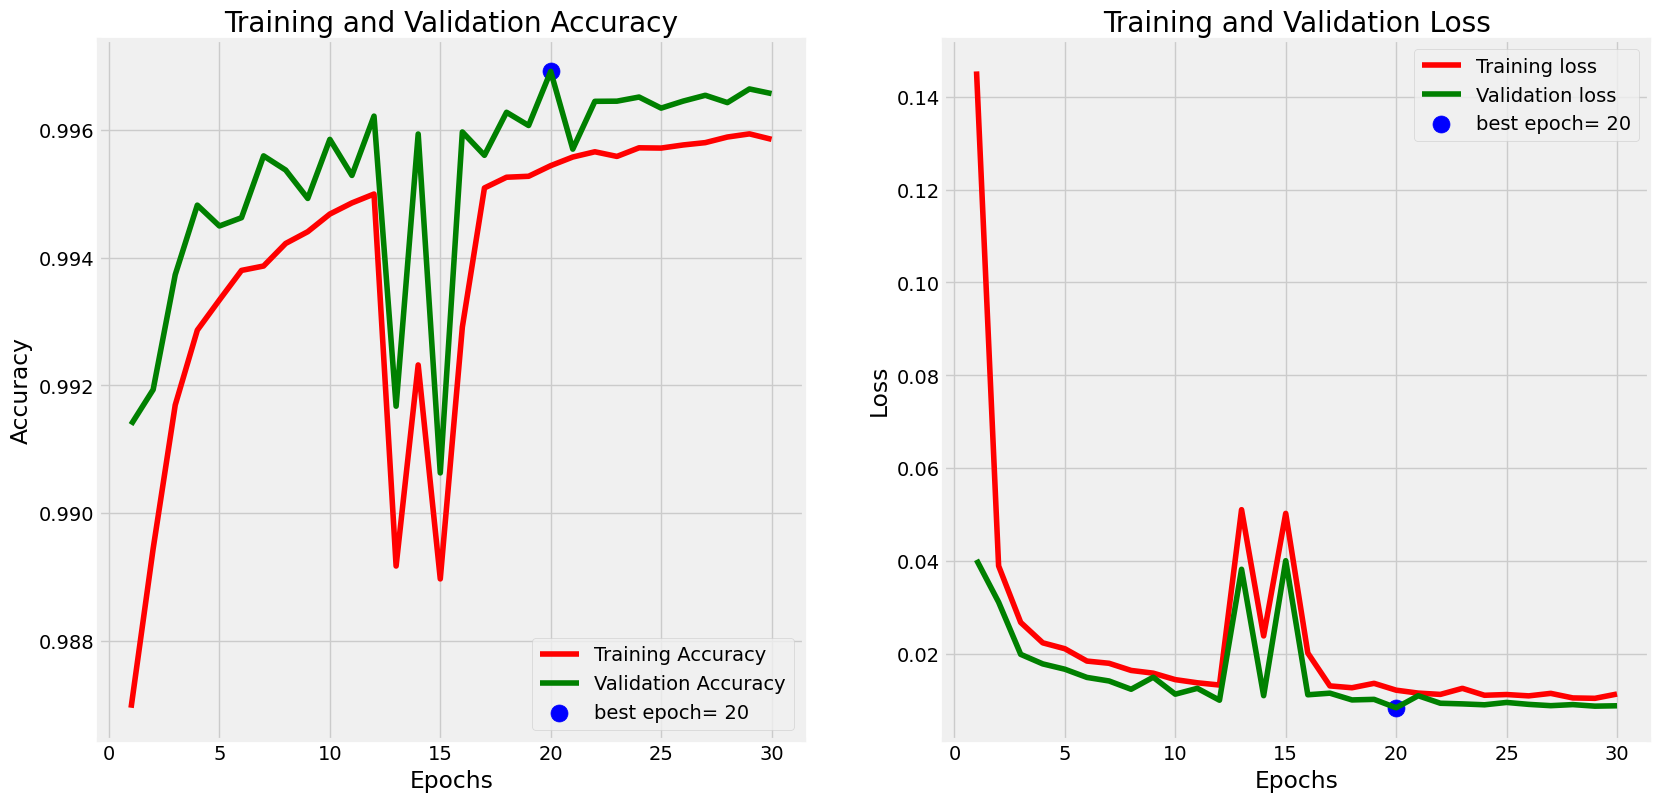

In [ ]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']

    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']

    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]

    Epochs = [i+1 for i in range(len(tr_acc))]

    acc_label = f'best epoch= {str(index_acc + 1)}'
    loss_label = f'best epoch= {str(index_loss + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 20))
    plt.style.use('fivethirtyeight')

    # Training Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Training Loss
    plt.subplot(2, 2, 2)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout
    plt.show()

plot_training(hist)

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = deepmodel.evaluate(train_generator, steps= test_steps, verbose= 1)
valid_score = deepmodel.evaluate(val_generator, steps= test_steps, verbose= 1)
test_score = deepmodel.evaluate(test_generator, steps= test_steps, verbose= 1)


print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])

print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])


print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

131/131 [==============================] - 6s 43ms/step - loss: 0.0090 - accuracy: 0.9965 - precision: 0.8409 - recall: 0.7285
Found 393 validated image filenames.
Found 393 validated image filenames.
131/131 [==============================] - 6s 47ms/step - loss: 0.0104 - accuracy: 0.9959 - precision: 0.8383 - recall: 0.7312
Train Loss:  0.009925671853125095
Train Accuracy:  0.996088981628418
Valid Loss:  0.009042646735906601
Valid Accuracy:  0.9964590668678284
Test Loss:  0.010434632189571857
Test Accuracy:  0.9958975911140442


# 2. UNet

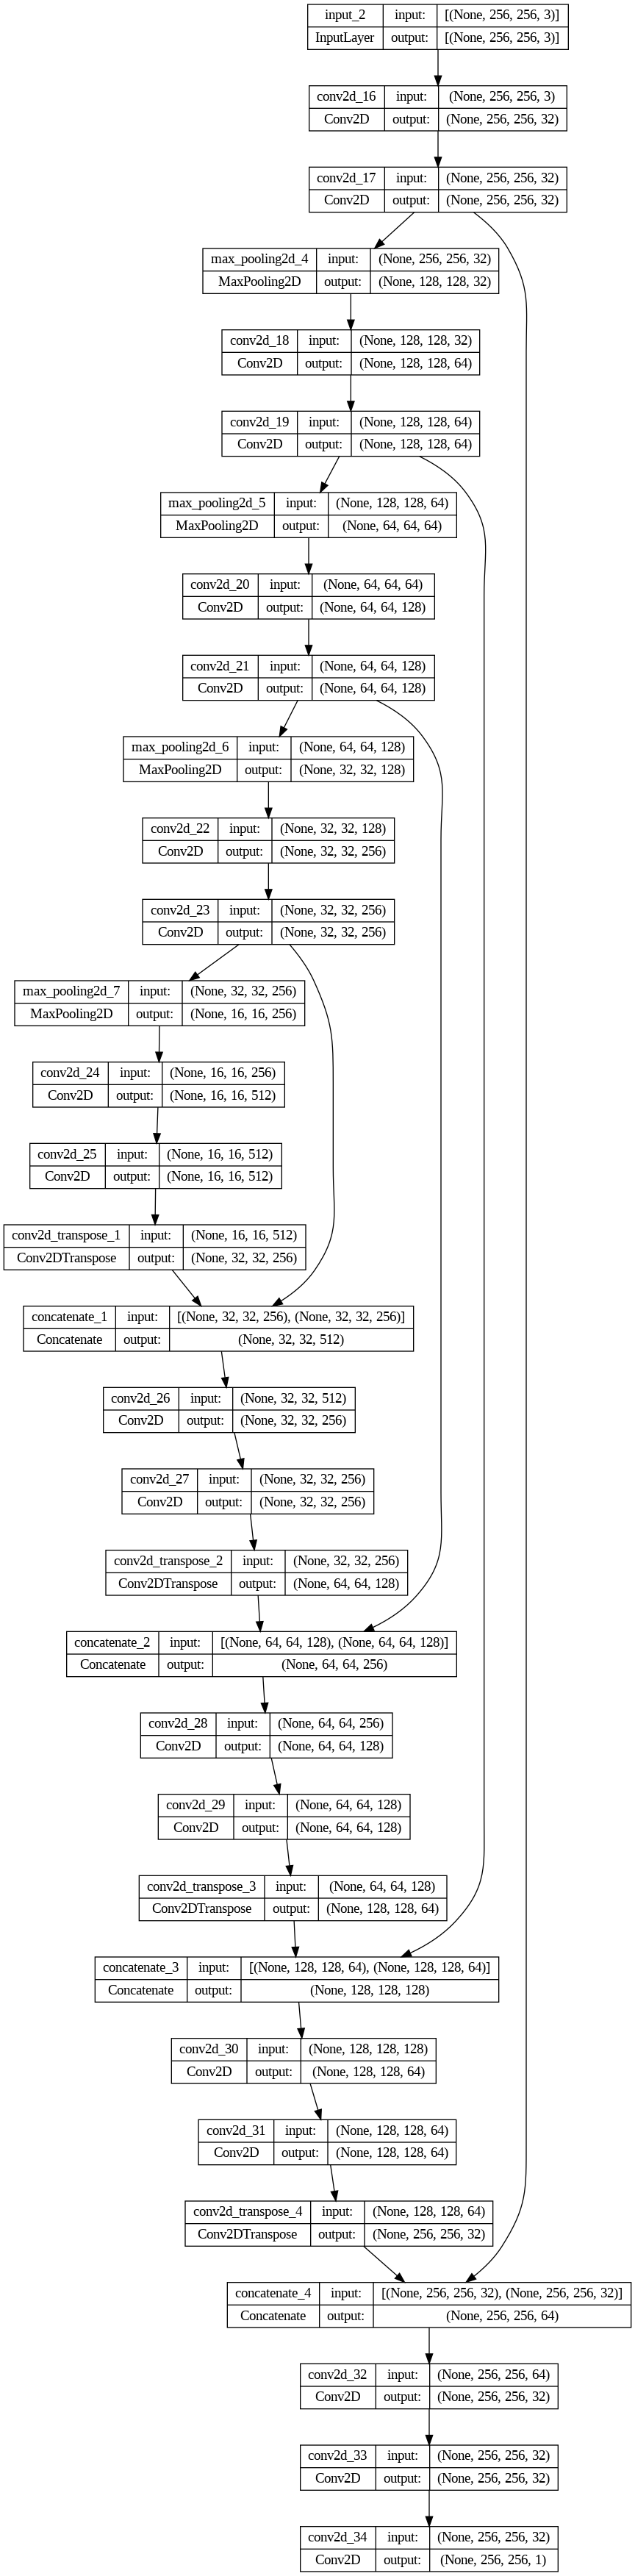

In [ ]:
def unet_model():
    inputs = Input((SIZE, SIZE, 3))

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
    merge6 = concatenate([conv4, up6])
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
    merge7 = concatenate([conv3, up7])
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    merge8 = concatenate([conv2, up8])
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8)
    merge9 = concatenate([conv1, up9])
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(merge9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[outputs])

    display(tf.keras.utils.plot_model(model, to_file='unet.png', show_shapes=True))

    return model

umodel = unet_model()

In [ ]:
umodel.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
def scheduler(epoch, lr):
      if epoch < 5:
        return lr
      else:
        return lr * tf.math.exp(-0.1)


log_dir='./logs/fit'+datetime.now().strftime('%d.%m.%Y--%H-%M-%S')
model_path='/content/model_2.h5'
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy',
                             verbose=1, save_best_only=True,
                             save_weights_only=False, mode='auto',
                             save_freq='epoch')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10,verbose=1, mode='auto')
board=TensorBoard(log_dir=log_dir,histogram_freq=1)
dec=LearningRateScheduler(scheduler)
tensorboard_callback =[checkpoint,early,board,dec]

In [ ]:
hist2 = umodel.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=len(train_df) / BATCH_SIZE,
    validation_steps=len(valid_df) / BATCH_SIZE,
    callbacks=[tensorboard_callback]
)


Epoch 1/100
197/196 [==============================] - ETA: 0s - loss: 0.1669 - accuracy: 0.9865 - precision_1: 0.0117 - recall_1: 0.0032
Epoch 1: val_accuracy improved from -inf to 0.99171, saving model to /content/model_2.h5
196/196 [==============================] - 69s 306ms/step - loss: 0.1669 - accuracy: 0.9865 - precision_1: 0.0117 - recall_1: 0.0032 - val_loss: 0.0278 - val_accuracy: 0.9917 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/100
197/196 [==============================] - ETA: 0s - loss: 0.0313 - accuracy: 0.9893 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 2: val_accuracy did not improve from 0.99171
196/196 [==============================] - 58s 298ms/step - loss: 0.0313 - accuracy: 0.9893 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 0.0250 - val_accuracy: 0.9911 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/100
197/196 [==============================] - ETA: 0s - loss:

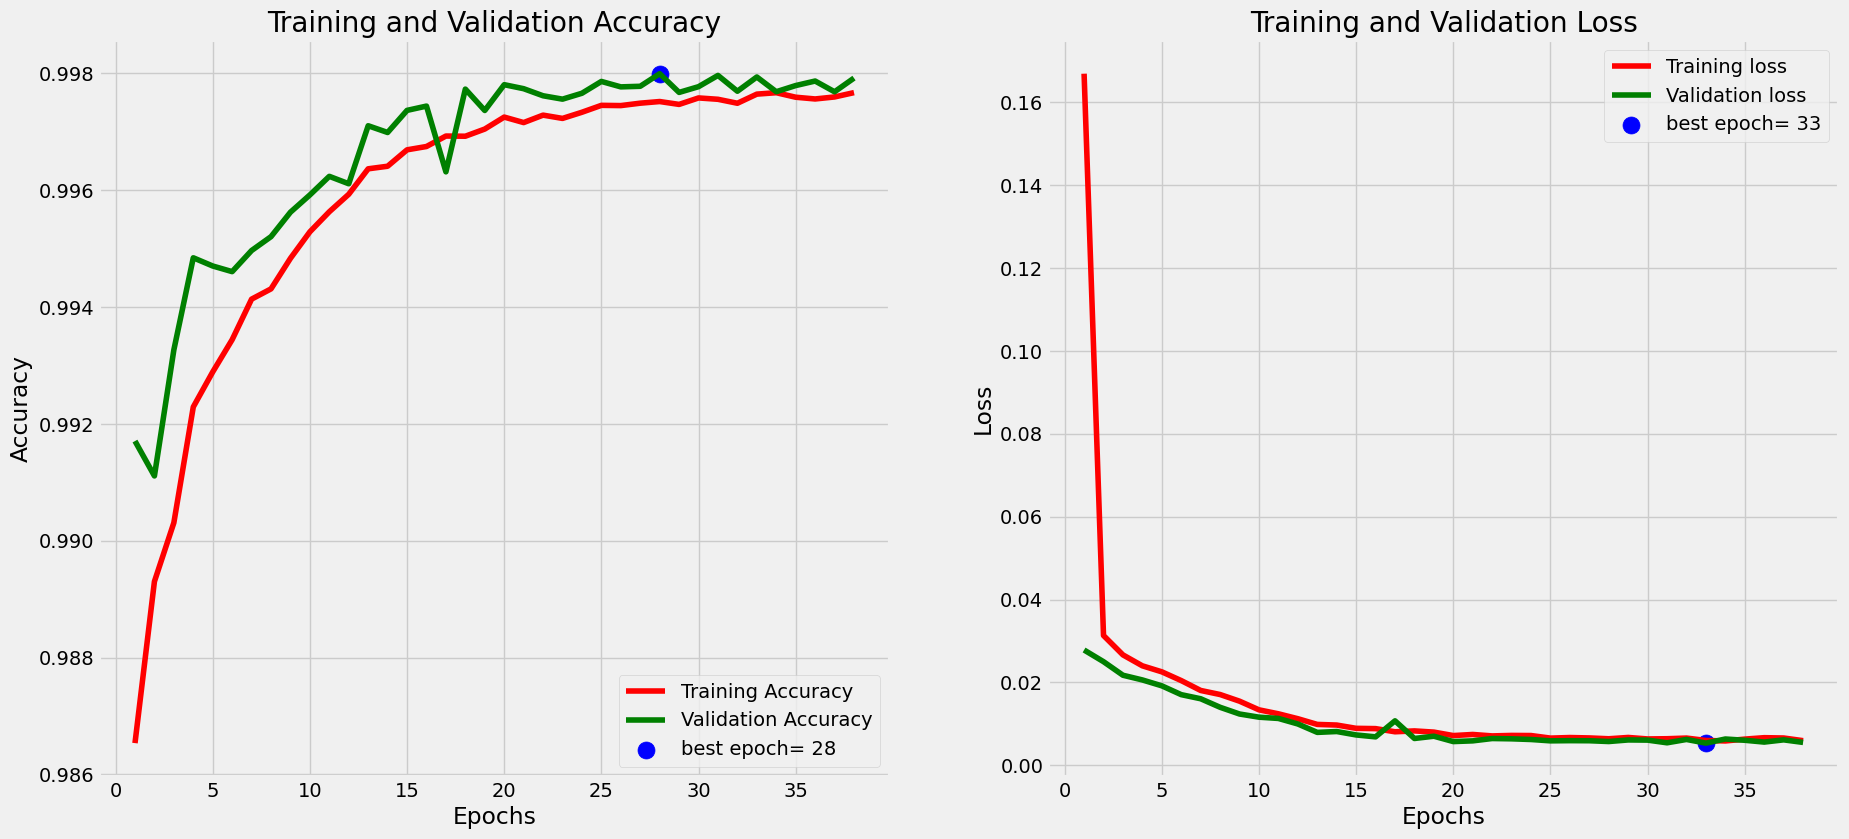

In [ ]:
plot_training(hist2)

In [ ]:
train2_score = umodel.evaluate(train_generator, steps= test_steps, verbose= 1)
valid2_score = umodel.evaluate(val_generator, steps= test_steps, verbose= 1)
test2_score = umodel.evaluate(test_generator, steps= test_steps, verbose= 1)


print("Train Loss: ", train2_score[0])
print("Train Accuracy: ", train2_score[1])

print("Valid Loss: ", valid2_score[0])
print("Valid Accuracy: ", valid2_score[1])


print("Test Loss: ", test2_score[0])
print("Test Accuracy: ", test2_score[1])

131/131 [==============================] - 6s 46ms/step - loss: 0.0063 - accuracy: 0.9976 - precision_1: 0.8832 - recall_1: 0.8787
Train Loss:  0.00594680942595005
Train Accuracy:  0.9976195693016052
Valid Loss:  0.0055793956853449345
Valid Accuracy:  0.9978826642036438
Test Loss:  0.0063034710474312305
Test Accuracy:  0.9975610971450806


#3. SegNet


In [ ]:
def segnet_model():
    # Encoder
    inputs = Input((SIZE,SIZE, 3))
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    pool1 = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    pool2 = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    pool3 = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    pool4 = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    pool5 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Decoder
    x = UpSampling2D(size=(2, 2))(pool5)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

SegNet = segnet_model()


In [ ]:
SegNet.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
def scheduler(epoch, lr):
      if epoch < 5:
        return lr
      else:
        return lr * tf.math.exp(-0.1)


log_dir='./logs/fit'+datetime.now().strftime('%d.%m.%Y--%H-%M-%S')
model_path='/content/model_3.h5'
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy',
                             verbose=1, save_best_only=True,
                             save_weights_only=False, mode='auto',
                             save_freq='epoch')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10,verbose=1, mode='auto')
board=TensorBoard(log_dir=log_dir,histogram_freq=1)
dec=LearningRateScheduler(scheduler)
tensorboard_callback =[checkpoint,early,board,dec]

In [ ]:
hist3 = SegNet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=len(train_df) / BATCH_SIZE,
    validation_steps=len(valid_df) / BATCH_SIZE,
    callbacks=[tensorboard_callback]
)


Epoch 1/100
197/196 [==============================] - ETA: 0s - loss: 0.0884 - accuracy: 0.9894 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00
Epoch 1: val_accuracy improved from -inf to 0.99165, saving model to /content/model_3.h5
196/196 [==============================] - 79s 348ms/step - loss: 0.0884 - accuracy: 0.9894 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 0.0328 - val_accuracy: 0.9917 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/100
197/196 [==============================] - ETA: 0s - loss: 0.0376 - accuracy: 0.9894 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00
Epoch 2: val_accuracy did not improve from 0.99165
196/196 [==============================] - 65s 334ms/step - loss: 0.0376 - accuracy: 0.9894 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 0.0334 - val_accuracy: 0.9906 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/100
197/196 [==============================] -

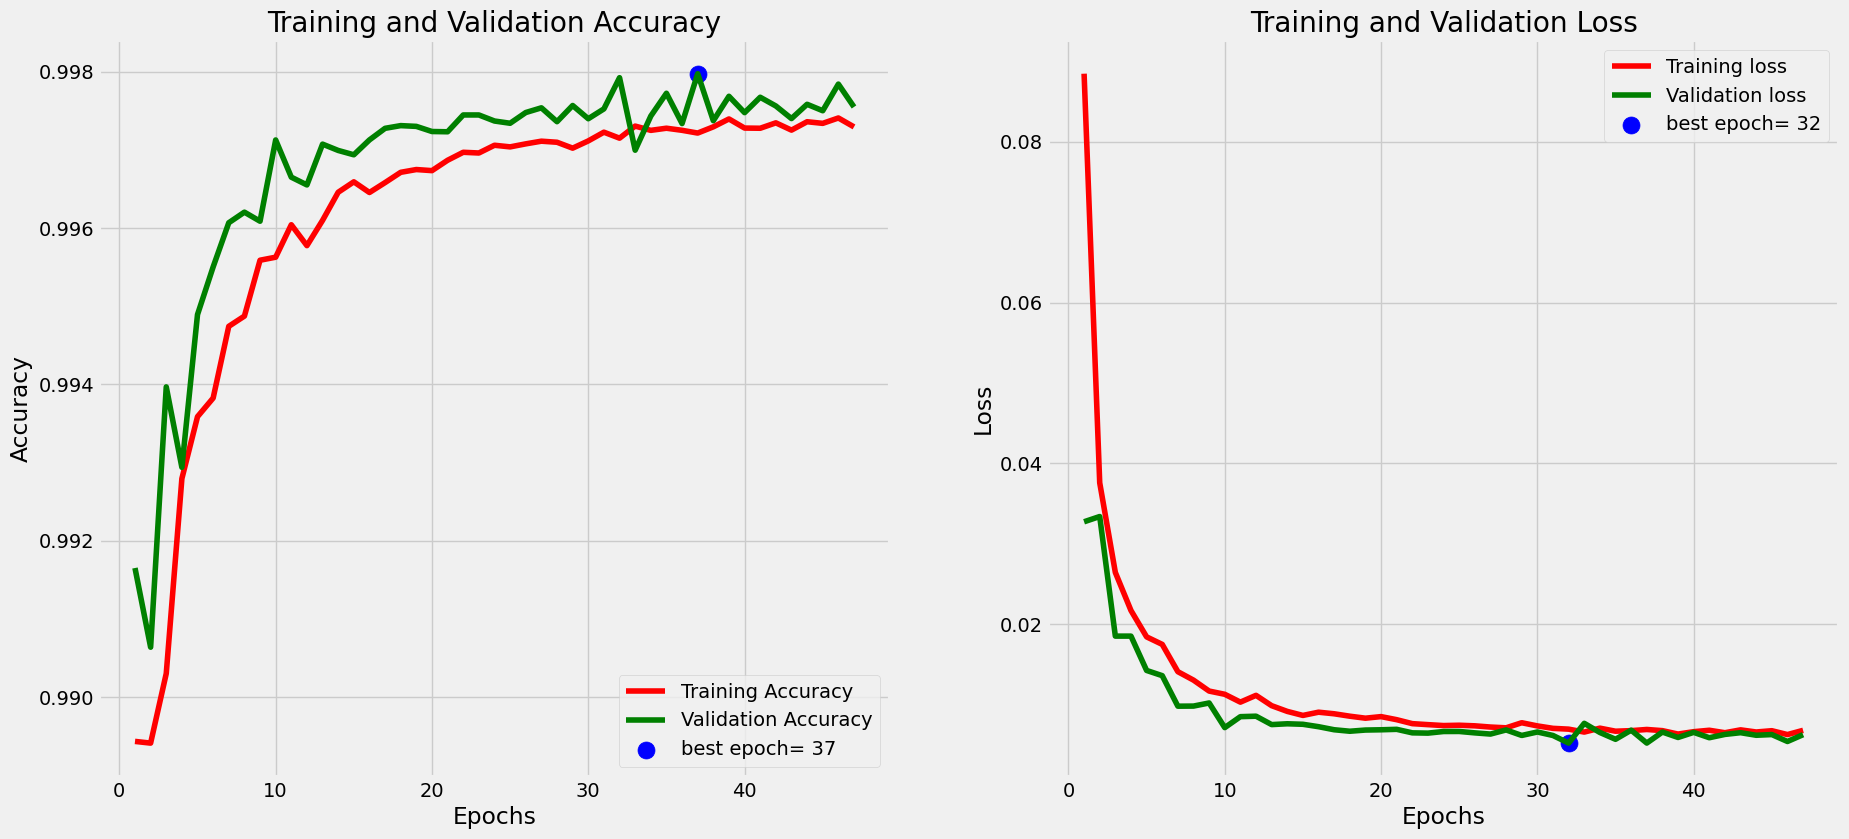

In [ ]:
plot_training(hist3)

In [ ]:
train3_score = SegNet.evaluate(train_generator, steps= test_steps, verbose= 1)
valid3_score = SegNet.evaluate(val_generator, steps= test_steps, verbose= 1)
test3_score = SegNet.evaluate(test_generator, steps= test_steps, verbose= 1)


print("Train Loss: ", train3_score[0])
print("Train Accuracy: ", train3_score[1])

print("Valid Loss: ", valid3_score[0])
print("Valid Accuracy: ", valid2_score[1])


print("Test Loss: ", test3_score[0])
print("Test Accuracy: ", test3_score[1])

131/131 [==============================] - 7s 53ms/step - loss: 0.0075 - accuracy: 0.9972 - precision_2: 0.8721 - recall_2: 0.8414
Train Loss:  0.0063765402883291245
Train Accuracy:  0.9973634481430054
Valid Loss:  0.0063258628360927105
Valid Accuracy:  0.9978826642036438
Test Loss:  0.007482399698346853
Test Accuracy:  0.9971804618835449


# 4. TransUnet


In [ ]:
def transunet_model():
    inputs = Input((SIZE,SIZE,3))

    #Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck (Transformer-like self-attention module)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Decoder
    up6 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv5)
    concat6 = concatenate([conv3, up6], axis=3)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(concat6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv6)
    concat7 = concatenate([conv2, up7], axis=3)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(concat7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv7)
    concat8 = concatenate([conv1, up8], axis=3)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(concat8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(conv8)

    # Output
    output = Conv2D(1, 1, activation='sigmoid')(conv8)

    # Create the TransUNet model
    model = Model(inputs=inputs, outputs=output)

    return model

tumodel = transunet_model()

In [ ]:
tumodel.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
def scheduler(epoch, lr):
      if epoch < 5:
        return lr
      else:
        return lr * tf.math.exp(-0.1)


log_dir='./logs/fit'+datetime.now().strftime('%d.%m.%Y--%H-%M-%S')
model_path='/content/model_4.h5'
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy',
                             verbose=1, save_best_only=True,
                             save_weights_only=False, mode='auto',
                             save_freq='epoch')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10,verbose=1, mode='auto')
board=TensorBoard(log_dir=log_dir,histogram_freq=1)
dec=LearningRateScheduler(scheduler)
tensorboard_callback =[checkpoint,early,board,dec]

In [ ]:
hist4 = tumodel.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=len(train_df) / BATCH_SIZE,
    validation_steps=len(valid_df) / BATCH_SIZE,
    callbacks=[tensorboard_callback]
)

Epoch 1/100
197/196 [==============================] - ETA: 0s - loss: 0.1329 - accuracy: 0.9887 - precision_3: 2.7220e-04 - recall_3: 1.9295e-05
Epoch 1: val_accuracy improved from -inf to 0.99252, saving model to /content/model_4.h5
196/196 [==============================] - 71s 323ms/step - loss: 0.1329 - accuracy: 0.9887 - precision_3: 2.7220e-04 - recall_3: 1.9295e-05 - val_loss: 0.0244 - val_accuracy: 0.9925 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/100
197/196 [==============================] - ETA: 0s - loss: 0.0285 - accuracy: 0.9897 - precision_3: 0.6594 - recall_3: 0.0339
Epoch 2: val_accuracy improved from 0.99252 to 0.99335, saving model to /content/model_4.h5
196/196 [==============================] - 61s 312ms/step - loss: 0.0285 - accuracy: 0.9897 - precision_3: 0.6594 - recall_3: 0.0339 - val_loss: 0.0209 - val_accuracy: 0.9934 - val_precision_3: 0.6858 - val_recall_3: 0.3705 - lr: 1.0000e-04
Epoch 3/100
197/196 [================

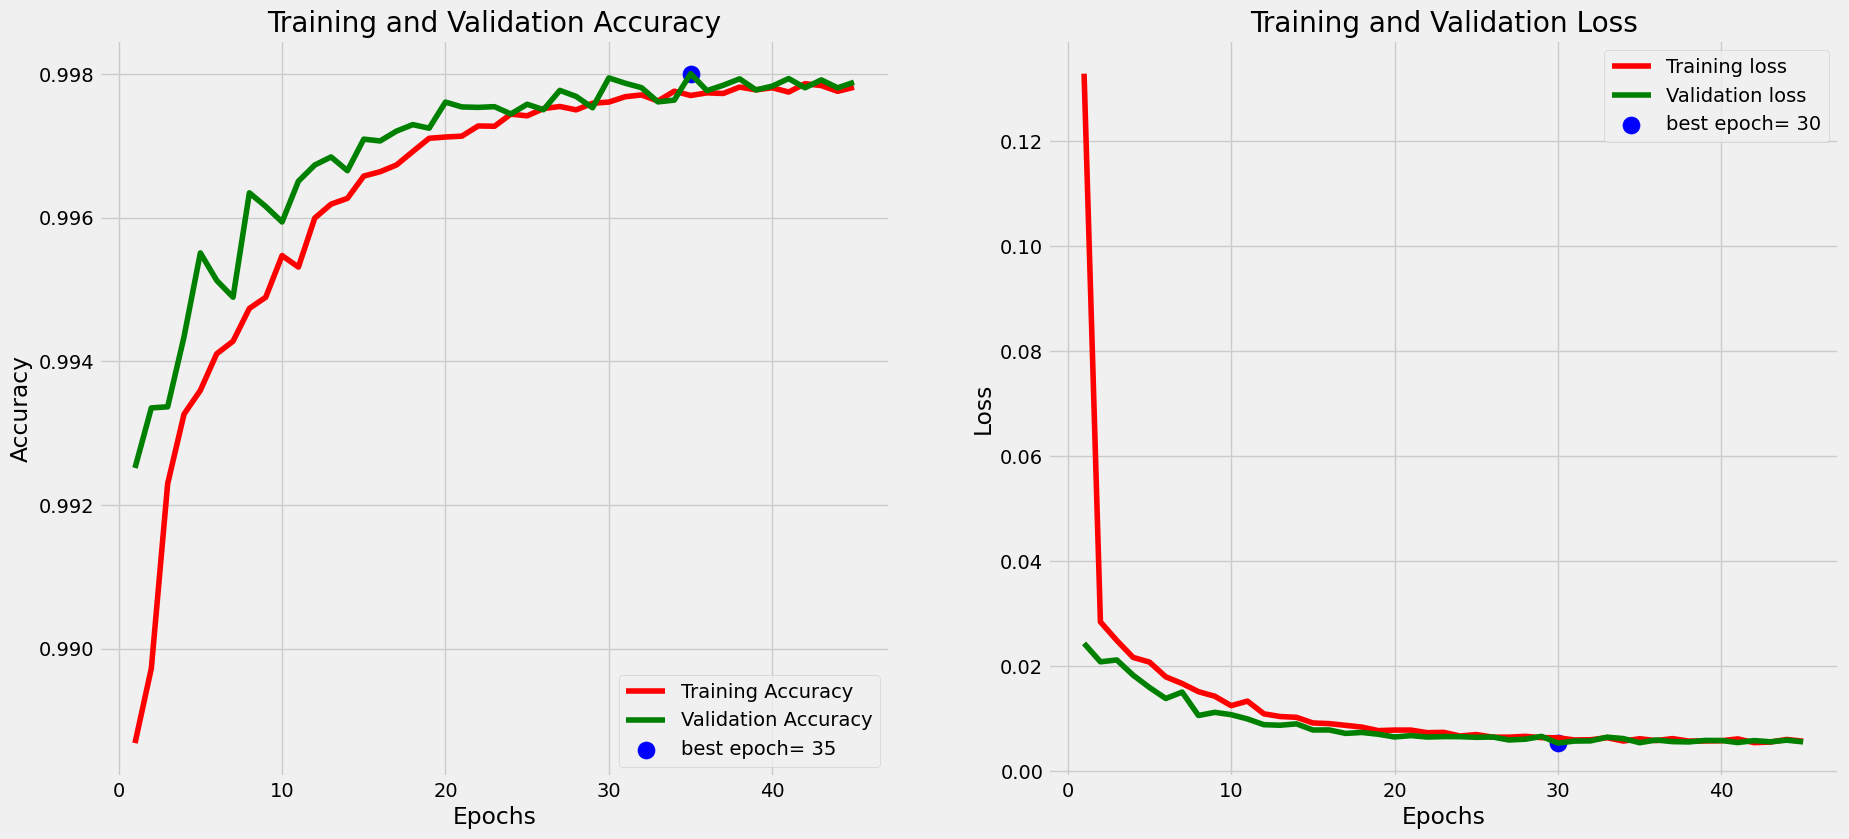

In [ ]:
plot_training(hist4)

In [ ]:
train4_score = tumodel.evaluate(train_generator, steps= test_steps, verbose= 1)
valid4_score = tumodel.evaluate(val_generator, steps= test_steps, verbose= 1)
test4_score = tumodel.evaluate(test_generator, steps= test_steps, verbose= 1)


print("Train Loss: ", train4_score[0])
print("Train Accuracy: ", train4_score[1])

print("Valid Loss: ", valid4_score[0])
print("Valid Accuracy: ", valid2_score[1])


print("Test Loss: ", test4_score[0])
print("Test Accuracy: ", test4_score[1])

131/131 [==============================] - 7s 51ms/step - loss: 0.0066 - accuracy: 0.9975 - precision_3: 0.8885 - recall_3: 0.8603
Train Loss:  0.005424095317721367
Train Accuracy:  0.9978763461112976
Valid Loss:  0.005665007513016462
Valid Accuracy:  0.9978826642036438
Test Loss:  0.006551780737936497
Test Accuracy:  0.9975278377532959


# UNet++


In [ ]:
def UNetPlus():

  inputs = Input((SIZE,SIZE,3))
  conv1 = Conv2D(32, (3,3), activation='relu', padding='same')(inputs) #1_1
  conv1 = Conv2D(32, (3,3), activation='relu', padding='same')(conv1)
  pool1 = MaxPooling2D((2, 2))(conv1)

  conv2 = Conv2D(64, (3,3), activation='relu', padding='same')(pool1) #2_1
  conv2 = Conv2D(64, (3,3), activation='relu', padding='same')(conv2)
  pool2 = MaxPooling2D((2, 2))(conv2)

  up1 = UpSampling2D((2, 2))(conv2) #1_2

  merge1 = concatenate([up1, conv1])
  conv3 = Conv2D(32, (3,3), activation='relu', padding='same')(merge1) #1_2
  conv3 = Conv2D(32, (3,3), activation='relu', padding='same')(conv3)

  conv4 = Conv2D(128, (3,3), activation='relu', padding='same')(pool2) #3_1
  conv4 = Conv2D(128, (3,3), activation='relu', padding='same')(conv4)
  pool3 = MaxPooling2D(pool_size = (2,2))(conv4)

  up2 = UpSampling2D((2,2))(conv4) #2_2

  merge2= concatenate([up2, conv2])
  conv5 = Conv2D(64, (3,3), activation='relu', padding='same')(merge2) #2_2
  conv5 = Conv2D(64, (3,3), activation='relu', padding='same')(conv5)

  up3 = UpSampling2D((2,2))(conv5)#1_3

  merge3 = concatenate([up3, conv1, conv3])
  conv6 = Conv2D(32, (3,3), activation='relu', padding='same')(merge3) #1_3
  conv6 = Conv2D(32, (3,3), activation='relu', padding='same')(conv6)

  conv7 = Conv2D(256, (3,3), activation='relu', padding='same')(pool3) #4_1
  conv7 = Conv2D(256, (3,3), activation='relu', padding='same')(conv7)
  pool4 = MaxPooling2D((2, 2))(conv7)

  up4 = UpSampling2D((2,2))(conv7)#3_2

  merge4 = concatenate([up4, conv4])
  conv8 = Conv2D(256, (3,3), activation='relu', padding='same')(merge4) #3_2
  conv8 = Conv2D(256, (3,3), activation='relu', padding='same')(conv8)

  up5 = UpSampling2D((2,2))(conv8) #2_3

  merge5 = concatenate([up5, conv2, conv5])
  conv9 = Conv2D(64, (3,3), activation='relu', padding='same')(merge5)#2_3
  conv9 = Conv2D(64, (3,3), activation='relu', padding='same')(conv9)

  up6 = UpSampling2D((2,2))(conv9)#1_4

  merge6 = concatenate([up6,conv1, conv3, conv6])
  conv10 = Conv2D(32, (3,3), activation='relu', padding='same')(merge6)#1_4
  conv10 = Conv2D(32, (3,3), activation='relu', padding='same')(conv10)

  conv11 = Conv2D(512, (3,3), activation='relu', padding='same')(pool4)#5_1
  conv11 = Conv2D(512, (3,3), activation='relu', padding='same')(conv11)

  up7 = UpSampling2D((2,2))(conv11)#4_2

  merge7 = concatenate([up7, conv7])
  conv12 = Conv2D(256, (3,3), activation='relu', padding='same')(merge7)#4_2
  conv12 = Conv2D(256, (3,3), activation='relu', padding='same')(conv12)

  up8 = UpSampling2D((2,2))(conv12)#3_3

  merge8 = concatenate([up8, conv4, conv8])
  conv13 = Conv2D(128, (3,3), activation='relu', padding='same')(merge8)#3_3
  conv13 = Conv2D(128, (3,3), activation='relu', padding='same')(conv13)

  up9 = UpSampling2D((2,2))(conv13)#2_4

  merge9 = concatenate([up9, conv2, conv5, conv9])
  conv14 = Conv2D(64, (3,3), activation='relu', padding='same')(merge9)#2_4
  conv14 = Conv2D(64, (3,3), activation='relu', padding='same')(conv14)

  up10 = UpSampling2D((2,2))(conv14)#1_5

  merge10 = concatenate([up10, conv1, conv3, conv6, conv10])
  conv15 = Conv2D(32, (3,3), activation='relu', padding='same')(merge10)#1_5
  conv15 = Conv2D(32, (3,3), activation='relu', padding='same')(conv15)

  output = Conv2D(1, (1,1), activation='sigmoid')(conv15)

  model = Model(inputs=[inputs], outputs=[output])

  return model

Uplus = UNetPlus()



In [ ]:
Uplus.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
def scheduler(epoch, lr):
      if epoch < 5:
        return lr
      else:
        return lr * tf.math.exp(-0.1)


log_dir='./logs/fit'+datetime.now().strftime('%d.%m.%Y--%H-%M-%S')
model_path='/content/model_5.h5'
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy',
                             verbose=1, save_best_only=True,
                             save_weights_only=False, mode='auto',
                             save_freq='epoch')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10,verbose=1, mode='auto')
board=TensorBoard(log_dir=log_dir,histogram_freq=1)
dec=LearningRateScheduler(scheduler)
tensorboard_callback =[checkpoint,early,board,dec]

In [ ]:
hist5 = Uplus.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=len(train_df) / BATCH_SIZE,
    validation_steps=len(valid_df) / BATCH_SIZE,
    callbacks=[tensorboard_callback]
)

Epoch 1/100
197/196 [==============================] - ETA: 0s - loss: 0.0902 - accuracy: 0.9833 - precision_4: 0.0124 - recall_4: 0.0073
Epoch 1: val_accuracy improved from -inf to 0.99155, saving model to /content/model_5.h5
196/196 [==============================] - 83s 347ms/step - loss: 0.0902 - accuracy: 0.9833 - precision_4: 0.0124 - recall_4: 0.0073 - val_loss: 0.0225 - val_accuracy: 0.9915 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/100
197/196 [==============================] - ETA: 0s - loss: 0.0267 - accuracy: 0.9912 - precision_4: 0.7160 - recall_4: 0.2582
Epoch 2: val_accuracy improved from 0.99155 to 0.99404, saving model to /content/model_5.h5
196/196 [==============================] - 64s 325ms/step - loss: 0.0267 - accuracy: 0.9912 - precision_4: 0.7160 - recall_4: 0.2582 - val_loss: 0.0195 - val_accuracy: 0.9940 - val_precision_4: 0.7599 - val_recall_4: 0.4022 - lr: 1.0000e-04
Epoch 3/100
197/196 [==============================] 

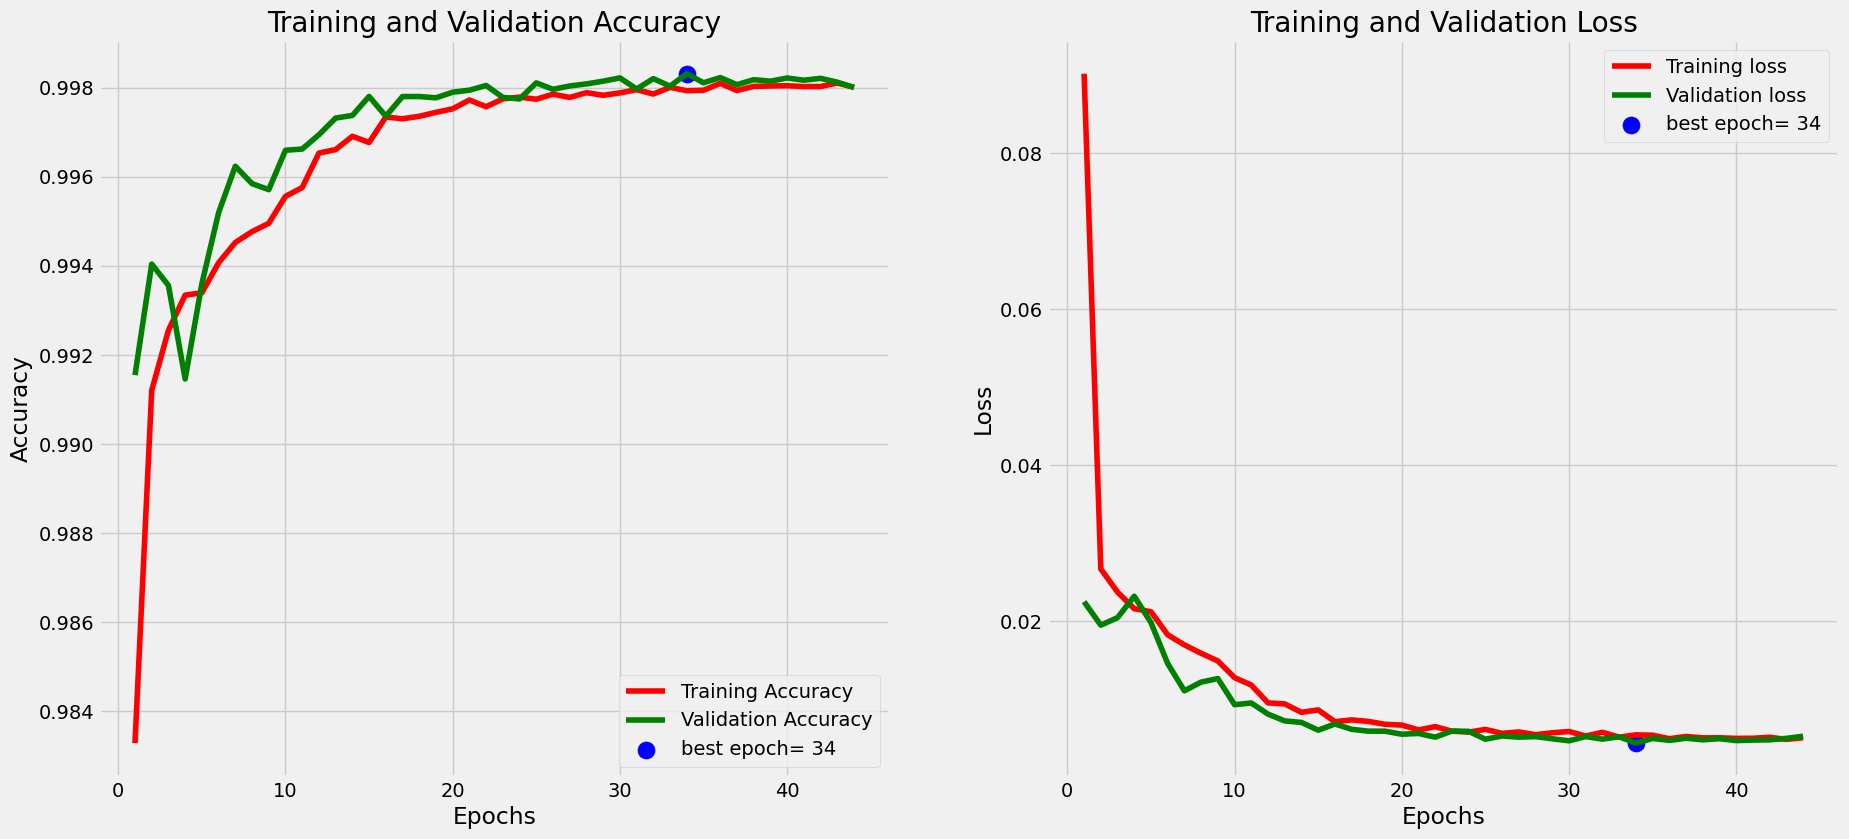

In [ ]:
plot_training(hist5)

In [ ]:
train4_score = Uplus.evaluate(train_generator, steps= test_steps, verbose= 1)
valid4_score = Uplus.evaluate(val_generator, steps= test_steps, verbose= 1)
test4_score = Uplus.evaluate(test_generator, steps= test_steps, verbose= 1)


print("Train Loss: ", train4_score[0])
print("Train Accuracy: ", train4_score[1])

print("Valid Loss: ", valid4_score[0])
print("Valid Accuracy: ", valid2_score[1])


print("Test Loss: ", test4_score[0])
print("Test Accuracy: ", test4_score[1])

131/131 [==============================] - 10s 78ms/step - loss: 0.0058 - accuracy: 0.9978 - precision_4: 0.8980 - recall_4: 0.8869
Train Loss:  0.0046117124147713184
Train Accuracy:  0.9981594085693359
Valid Loss:  0.004857267718762159
Valid Accuracy:  0.9978826642036438
Test Loss:  0.005802530329674482
Test Accuracy:  0.9978465437889099


# Model Benchmarking

1/1 [==============================] - 0s 22ms/step


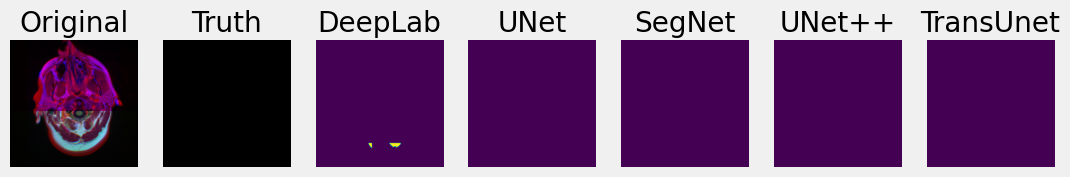

1/1 [==============================] - 0s 21ms/step


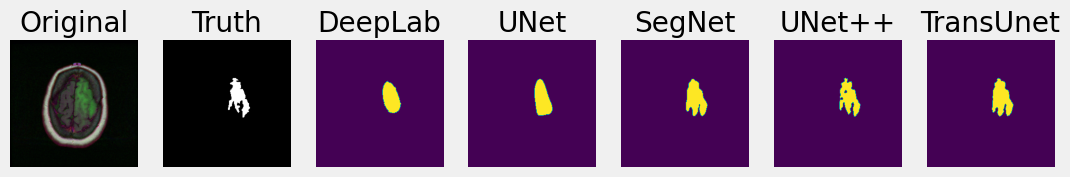

1/1 [==============================] - 0s 22ms/step


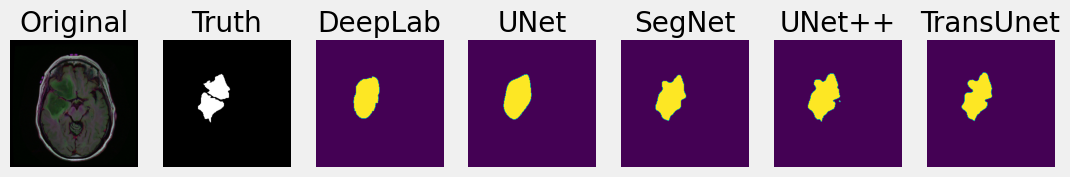

1/1 [==============================] - 0s 22ms/step


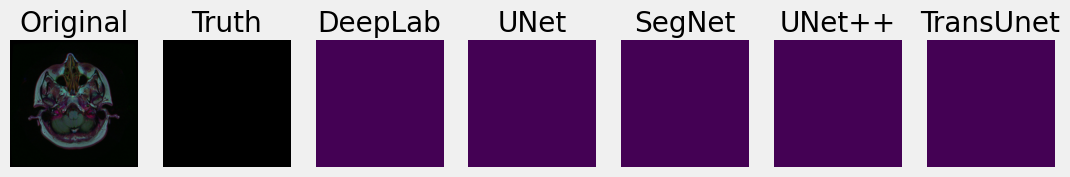

1/1 [==============================] - 0s 21ms/step


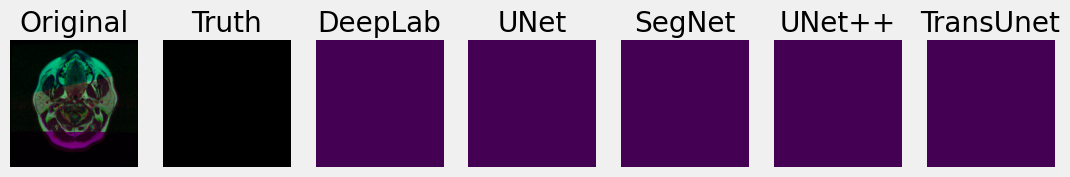

1/1 [==============================] - 0s 21ms/step


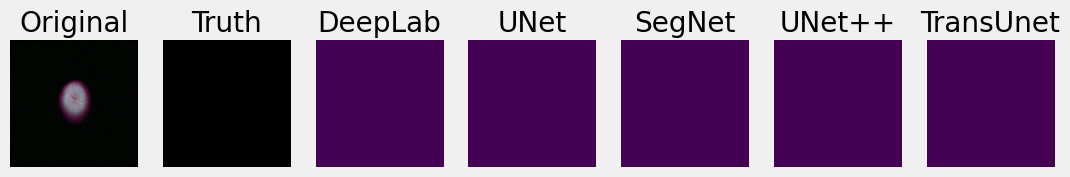

1/1 [==============================] - 0s 21ms/step


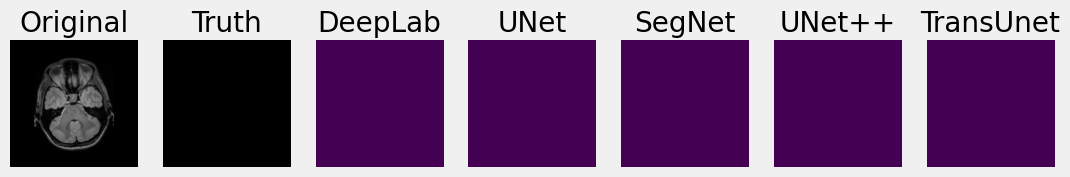

1/1 [==============================] - 0s 25ms/step


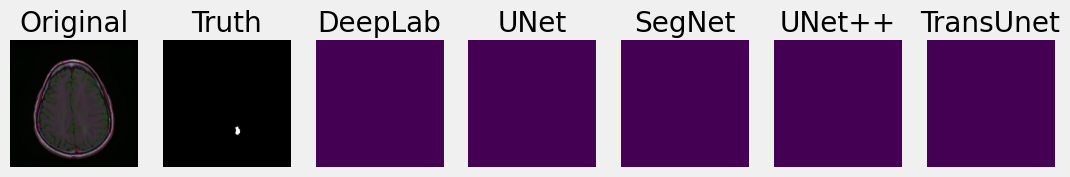

1/1 [==============================] - 0s 24ms/step


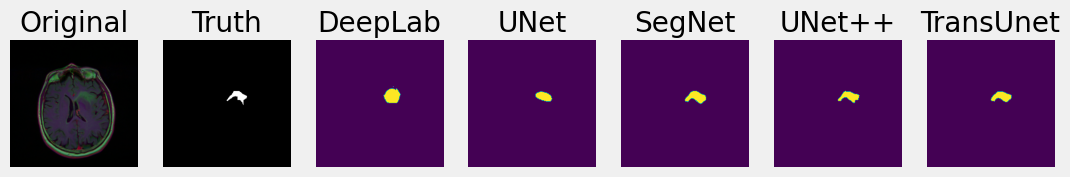

1/1 [==============================] - 0s 26ms/step


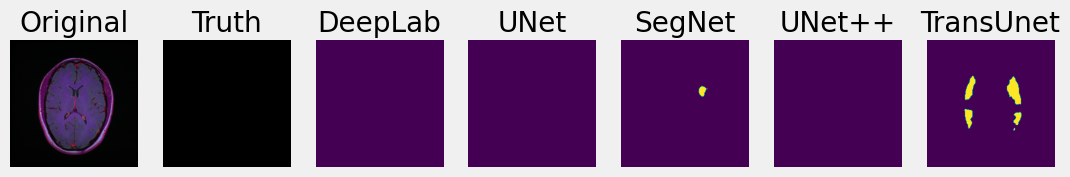

1/1 [==============================] - 0s 22ms/step


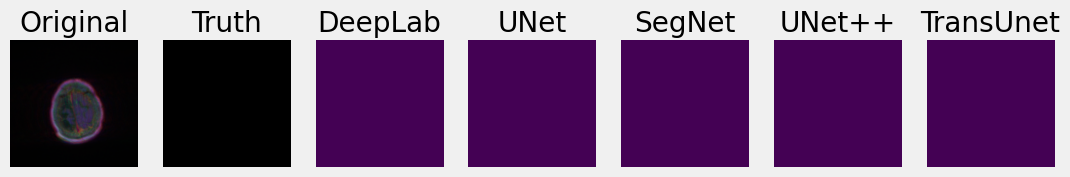

1/1 [==============================] - 0s 22ms/step


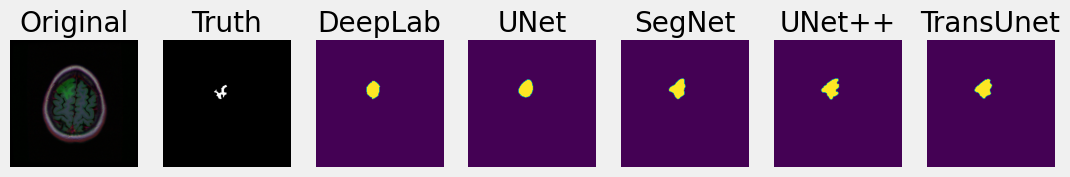

1/1 [==============================] - 0s 22ms/step


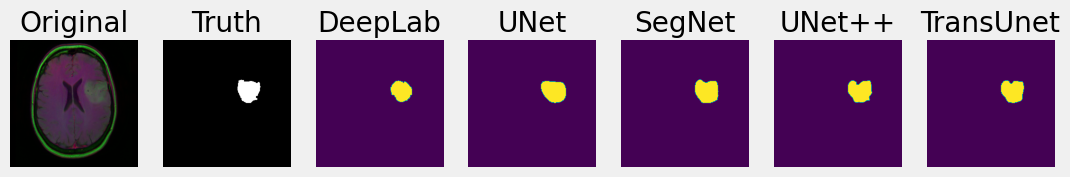

1/1 [==============================] - 0s 21ms/step


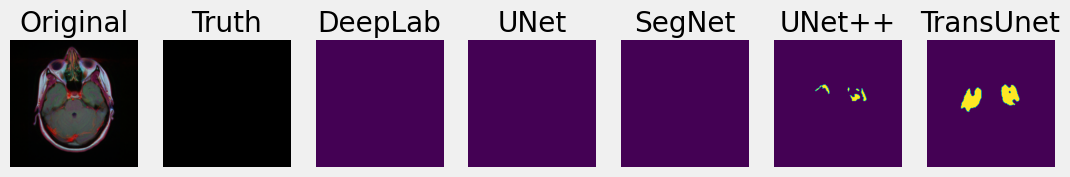

1/1 [==============================] - 0s 21ms/step


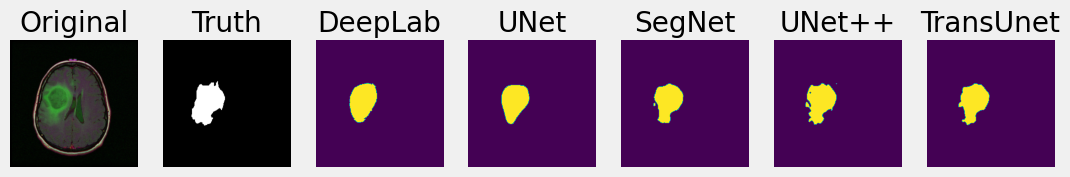

1/1 [==============================] - 0s 22ms/step


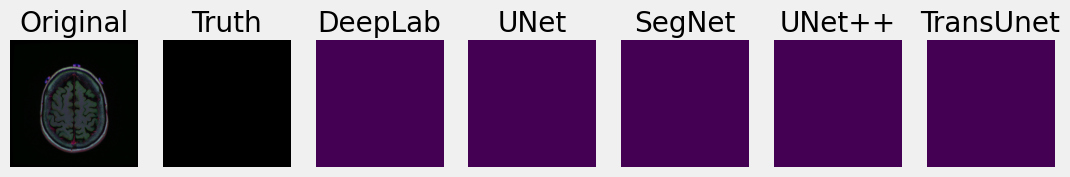

1/1 [==============================] - 0s 22ms/step


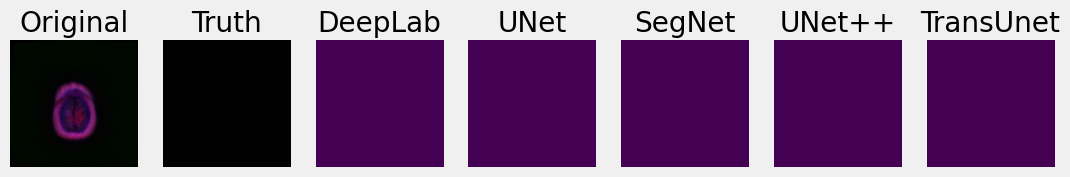

1/1 [==============================] - 0s 21ms/step


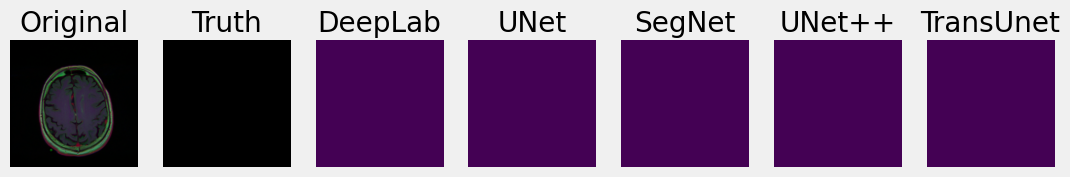

1/1 [==============================] - 0s 27ms/step


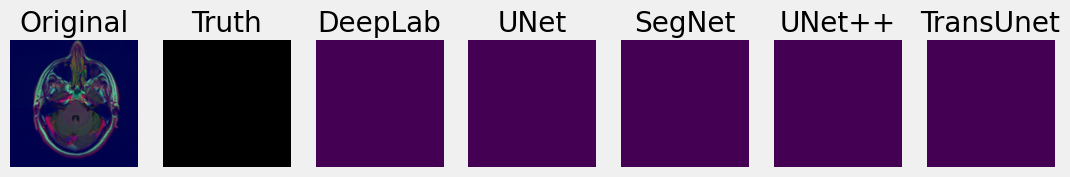

1/1 [==============================] - 0s 24ms/step


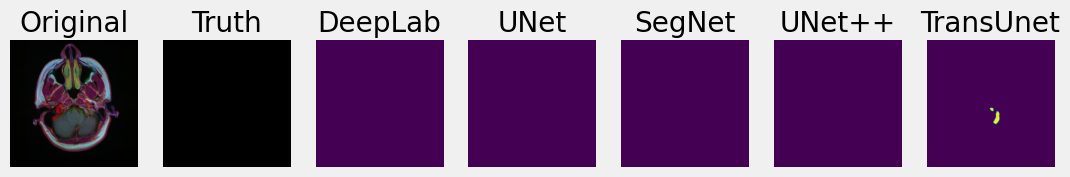

1/1 [==============================] - 0s 25ms/step


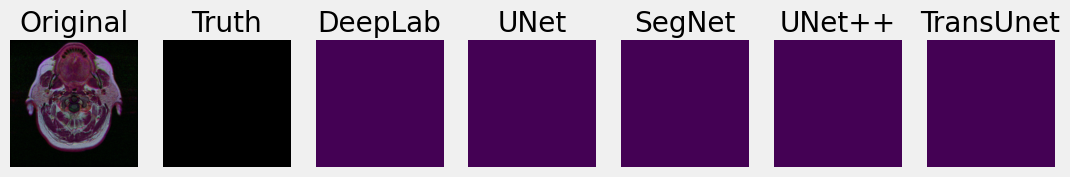

1/1 [==============================] - 0s 22ms/step


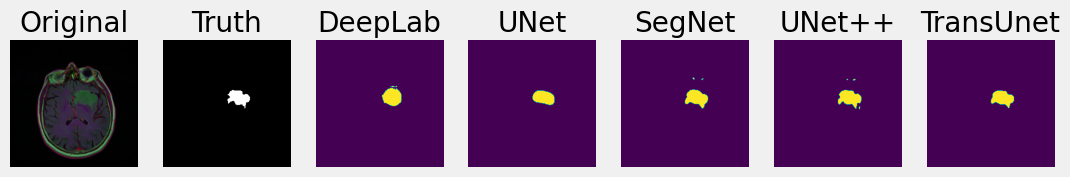

1/1 [==============================] - 0s 29ms/step


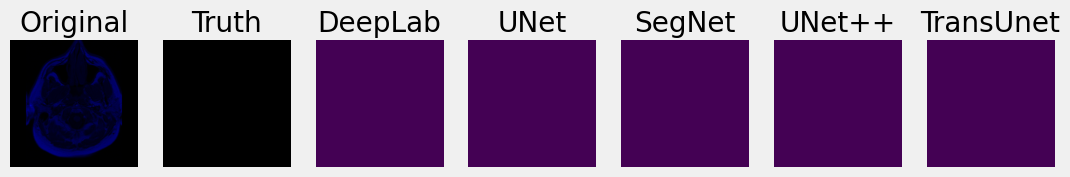

1/1 [==============================] - 0s 22ms/step


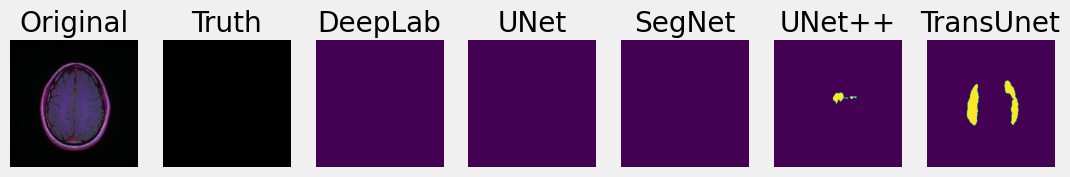

1/1 [==============================] - 0s 28ms/step


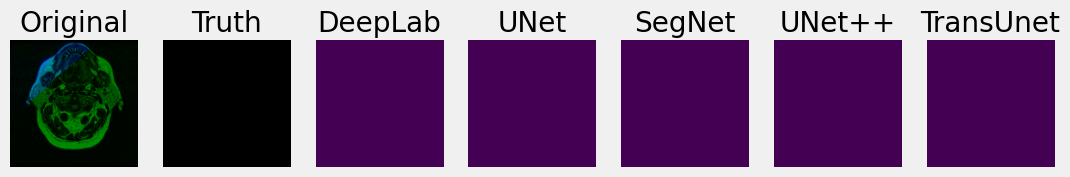

In [ ]:
for _ in range(25):
    index = np.random.randint(1, len(test_df.index))
    img = cv2.imread(test_df['images_paths'].iloc[index])
    img = cv2.resize(img, (256, 256))
    img = img/255
    img = img[np.newaxis, :, :, : ]

    deep_img = deepmodel.predict(img)
    unet_img = umodel.predict(img)
    segnet_img = SegNet.predict(img)
    tunet_img = tumodel.predict(img)
    uplus_img = Uplus.predict(img)
    plt.figure(figsize=(12, 12))

    plt.subplot(1, 7, 1)
    plt.imshow(np.squeeze(img))
    plt.axis('off')
    plt.title('Original')

    plt.subplot(1, 7, 2)
    plt.imshow(np.squeeze(cv2.imread(test_df['masks_paths'].iloc[index])))
    plt.axis('off')
    plt.title('Truth')

    plt.subplot(1, 7, 3)
    plt.imshow(np.squeeze(deep_img) > 0.5 )
    plt.title('DeepLab')
    plt.axis('off')

    plt.subplot(1, 7, 4)
    plt.imshow(np.squeeze(segnet_img) > 0.5 )
    plt.title('UNet')
    plt.axis('off')

    plt.subplot(1, 7, 5)
    plt.imshow(np.squeeze(unet_img) > 0.5)
    plt.title('SegNet')
    plt.axis('off')

    plt.subplot(1, 7, 6)
    plt.imshow(np.squeeze(uplus_img) > 0.5)
    plt.title('UNet++')
    plt.axis('off')

    plt.subplot(1, 7, 7)
    plt.imshow(np.squeeze(tunet_img) > 0.5)
    plt.title('TransUnet')
    plt.axis('off')

    plt.show()